# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\karth\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

In [ ]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [ ]:
preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

# Data importing

### Importing time sorted splitted data

In [26]:
import pickle
import sqlite3
import pandas as pd

In [2]:
pickle_in = open('train60k.pkl', 'rb')
x_train = pickle.load(pickle_in)

In [3]:
pickle_in = open('test20k.pkl', 'rb')
x_test = pickle.load(pickle_in)

In [4]:
pickle_in = open('cv20k.pkl', 'rb')
x_cv = pickle.load(pickle_in)

In [5]:
pickle_in = open('ytrain.pkl', 'rb')
y_train = pickle.load(pickle_in)

In [6]:
pickle_in = open('ytest.pkl', 'rb')
y_test = pickle.load(pickle_in)

In [7]:
pickle_in = open('ycv.pkl', 'rb')
y_cv = pickle.load(pickle_in)

In [8]:
pickle_in = open('train_tfidf.pkl', 'rb')
train_tfidf = pickle.load(pickle_in)

In [9]:
pickle_in = open('test_tfidf.pkl', 'rb')
test_tfidf = pickle.load(pickle_in)

In [10]:
pickle_in = open('cv_tfidf.pkl', 'rb')
cv_tfidf = pickle.load(pickle_in)

In [11]:
pickle_in = open('avgw2v_train.pkl', 'rb')
avgw2v_train = pickle.load(pickle_in)

In [12]:
pickle_in = open('avgw2v_test.pkl', 'rb')
avgw2v_test = pickle.load(pickle_in)

In [13]:
pickle_in = open('avgw2v_cv.pkl', 'rb')
avgw2v_cv = pickle.load(pickle_in)

In [14]:
pickle_in = open('tfidfw2v_train.pkl', 'rb')
tfidfw2v_train = pickle.load(pickle_in)

In [15]:
pickle_in = open('tfidfw2v_test.pkl', 'rb')
tfidfw2v_test = pickle.load(pickle_in)

In [16]:
pickle_in = open('tfidfw2v_cv.pkl', 'rb')
tfidfw2v_cv = pickle.load(pickle_in)

In [17]:
pickle_in = open('train_bow_count.pkl', 'rb')
train_bow_count = pickle.load(pickle_in)

In [18]:
pickle_in = open('test_bow_count.pkl', 'rb')
test_bow_count = pickle.load(pickle_in)

In [19]:
pickle_in = open('cv_bow_count.pkl', 'rb')
cv_bow_count = pickle.load(pickle_in)

In [27]:
df = pd.DataFrame(data=y_cv,columns=['Score'])

In [28]:
df.replace(to_replace=[1,2], value=0, inplace=True)

In [29]:
df.replace(to_replace=[5,4], value=1, inplace=True)

In [30]:
df = pd.DataFrame(data=y_test,columns=['Score'])

In [31]:
df.replace(to_replace=[1,2], value=0, inplace=True)

In [32]:
df.replace(to_replace=[5,4], value=1, inplace=True)

In [33]:
df = pd.DataFrame(data=y_train,columns=['Score'])

In [34]:
df.replace(to_replace=[1,2], value=0, inplace=True)

In [35]:
df.replace(to_replace=[5,4], value=1, inplace=True)

In [36]:
df.Score.value_counts()

1    53147
0     6853
Name: Score, dtype: int64

### Column Standardisation

In [37]:
import warnings
warnings.filterwarnings('ignore')

### countvectorizer with float

In [159]:
countvect = CountVectorizer(dtype='float', max_features=2000)

In [160]:
cv = countvect.fit(x_train)

In [161]:
train_bow = cv.transform(x_train)

In [162]:
test_bow = cv.transform(x_test)

In [163]:
cv_bow = cv.transform(x_cv)

In [164]:
std = StandardScaler(with_mean=False)

In [165]:
scaler = std.fit(train_bow)

In [166]:
standard_train_bow = scaler.transform(train_bow)

In [167]:
standard_test_bow = scaler.transform(test_bow)

In [168]:
standard_cv_bow = scaler.transform(cv_bow)

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [204]:
logreg=LogisticRegression(penalty='l1',random_state=42,n_jobs=2)

In [205]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [206]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [207]:
model.fit(standard_train_bow, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [208]:
model.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [209]:
model.best_score_

0.9591033566293468

### Building Logistic regression model based on result from GridSearch

In [210]:
logreg = LogisticRegression(C=0.1, penalty='l1', random_state=42, n_jobs=2)

In [211]:
logreg.fit(standard_train_bow, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [212]:
print('train error is ', 100 - (logreg.score(standard_train_bow, y_train)*100))

train error is  6.028333333333336


In [213]:
y_pred = logreg.predict(standard_test_bow)

In [214]:
f1 = f1_score(y_test, y_pred, average='micro')*100
print('the f1 score on testing set is %d%%' %(f1))

the f1 score on testing set is 91%


### Performance measures

In [215]:
cmat = confusion_matrix(y_test, y_pred)

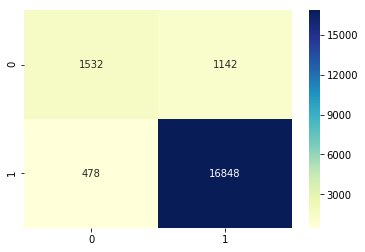

In [216]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [70]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [217]:
print('precision score for test set is ',(precision_score(y_test, y_pred)*100))

precision score for test set is  93.65202890494719


In [218]:
print('recall score for test set is ',(recall_score(y_test, y_pred)*100))

recall score for test set is  97.24114048251184


In [219]:
print('fbeta score for test set is ',(fbeta_score(y_test, y_pred, beta=0.5,average='micro')*100))

fbeta score for test set is  91.90000000000002


In [120]:
y_pred_prob = logreg.predict_proba(standard_test_bow)[:,1]

In [121]:
from sklearn.metrics import roc_curve,roc_auc_score

In [122]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

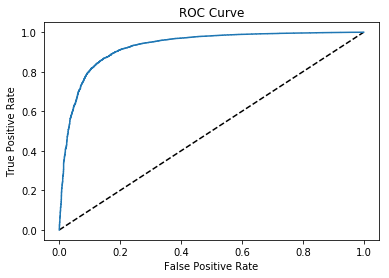

In [123]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [124]:
roc_auc_score(y_test, y_pred_prob)

0.9279618091400675

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [71]:
logreg.coef_.shape

(1, 2000)

In [89]:
squeezed=logreg.coef_.squeeze()

In [93]:
count=0
for i in squeezed:
    if (i==0).all():
        count+=1

In [97]:
print('sparsity of the weights is: {}'.format(count/len(squeezed)*100))

sparsity of the weights is: 12.9


In [3]:
# Please write all the code with proper documentation

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [169]:
logreg=LogisticRegression(penalty='l2',random_state=42,n_jobs=2)

In [170]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [171]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [172]:
model.fit(standard_train_bow, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [173]:
model.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

### Building Logistic regression model based on result from GridSearch

In [174]:
logreg = LogisticRegression(C=0.001, penalty='l2', random_state=42, n_jobs=2)

In [175]:
logreg.fit(standard_train_bow, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [176]:
print('train error is ', 100 - (logreg.score(standard_train_bow, y_train)*100))

train error is  6.291666666666657


In [177]:
y_pred = logreg.predict(standard_test_bow)

In [178]:
f1 = f1_score(y_test, y_pred, average='micro')*100
print('the f1 score on testing set is %d%%' %(f1))

the f1 score on testing set is 91%


### Performance measures

In [198]:
cmat = confusion_matrix(y_test, y_pred)

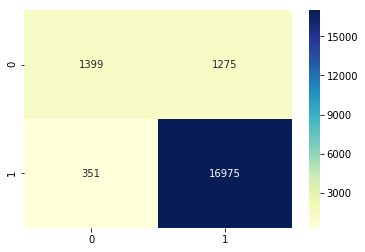

In [199]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [200]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [201]:
print('precision score for test set is ',(precision_score(y_test, y_pred)*100))

precision score for test set is  93.01369863013699


In [202]:
print('recall score for test set is ',(recall_score(y_test, y_pred)*100))

recall score for test set is  97.97414290661433


In [203]:
print('fbeta score for test set is ',(fbeta_score(y_test, y_pred, beta=0.5,average='micro')*100))

fbeta score for test set is  91.86999999999999


In [116]:
standard_test_bow.shape

(20000, 2000)

In [120]:
y_pred_prob = logreg.predict_proba(standard_test_bow)[:,1]

In [121]:
from sklearn.metrics import roc_curve,roc_auc_score

In [122]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

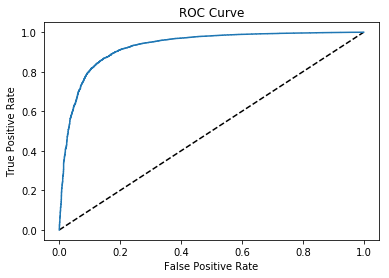

In [123]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [65]:
logreg

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
oldweights = logreg.coef_

In [67]:
oldweights.shape

(1, 2000)

In [81]:
standard_train_bow.data.shape

(1542745,)

In [68]:
noise = 0.00001

In [79]:
noisedbow = np.add(standard_train_bow.data, noise)

In [83]:
noisedbow.resize((60000,2000))

In [84]:
noisedbow.shape

(60000, 2000)

In [70]:
noisedlogreg = LogisticRegression(C=0.001, penalty='l2', random_state=42, n_jobs=2)

In [85]:
noisedlogreg.fit(noisedbow, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [86]:
newweights = noisedlogreg.coef_

In [87]:
epsilon = np.full(shape=oldweights.shape, fill_value=0.000001)

In [88]:
oldweights += epsilon

In [89]:
newweights += epsilon

In [90]:
change = (abs((oldweights - newweights)/(oldweights)))*100

In [94]:
feature_names = countvect.get_feature_names()

In [95]:
coefs_with_fns = sorted(zip(change[0], feature_names))

In [104]:
changed=[]
for i in coefs_with_fns:
    if i[0]>25:
        changed.append(i)
# coefs_with_fns[0]

In [100]:
len(coefs_with_fns)

2000

In [105]:
len(changed)

1937

In [68]:
np.percentile(a=change,q=[0,10,20,30,40,50,60,70,80,90,100])

array([1.07791246e-01, 6.02434128e+01, 8.06419373e+01, 8.94868030e+01,
       9.49671274e+01, 1.00041762e+02, 1.05856093e+02, 1.13264029e+02,
       1.28757845e+02, 1.65646174e+02, 2.32727347e+04])

In [70]:
np.percentile(a=change,q=[0,1,2,3,4,5,6,7,8,9])

array([ 0.10779125,  5.9989447 , 14.96595093, 24.59809531, 28.59470595,
       37.87709521, 43.4869458 , 47.31904246, 51.50657214, 55.84566625])

### As seen above, there are some sudden changes in range (0,10) percentiles

In [76]:
print('list of feature that changed more than threshold which is 25%:')
for i in changed:
    print(i)

list of feature that changed more than threshold which is 25%:
(25.093109492404153, 'lipton')
(25.494788115303514, 'newman')
(25.716717113474097, 'reorder')
(25.840132085119727, 'highest')
(26.120340857914808, 'websit')
(26.15123306076533, 'over')
(26.227291072165638, 'design')
(26.297537447527315, 'respect')
(26.862150990712525, 'stomach')
(27.055904608482535, 'coat')
(27.117728145746046, 'hungri')
(27.238309385664568, 'upon')
(27.33051897871056, 'assort')
(27.873118085994346, 'path')
(28.078383836093344, 'expens')
(28.251091745766182, 'adjust')
(28.433493253184245, 'loaf')
(28.60142314056826, 'veggi')
(28.862556917213922, 'rye')
(29.56830837819321, 'protect')
(30.70912451693281, 'honest')
(31.606575635658924, 'counter')
(32.64449264744351, 'apricot')
(33.05464746311796, 'attent')
(33.57262474425744, 'carbohydr')
(34.09226008561057, 'experi')
(35.372156503971894, 'reseal')
(35.56995674282115, 'let')
(36.04064225092355, 'unabl')
(36.20227037363837, 'brush')
(36.2884330362798, 'fatti')


In [107]:
for i in changed:
    print(i)

(25.093109492404153, 'lipton')
(25.494788115303514, 'newman')
(25.716717113474097, 'reorder')
(25.840132085119727, 'highest')
(26.120340857914808, 'websit')
(26.15123306076533, 'over')
(26.227291072165638, 'design')
(26.297537447527315, 'respect')
(26.862150990712525, 'stomach')
(27.055904608482535, 'coat')
(27.117728145746046, 'hungri')
(27.238309385664568, 'upon')
(27.33051897871056, 'assort')
(27.873118085994346, 'path')
(28.078383836093344, 'expens')
(28.251091745766182, 'adjust')
(28.433493253184245, 'loaf')
(28.60142314056826, 'veggi')
(28.862556917213922, 'rye')
(29.56830837819321, 'protect')
(30.70912451693281, 'honest')
(31.606575635658924, 'counter')
(32.64449264744351, 'apricot')
(33.05464746311796, 'attent')
(33.57262474425744, 'carbohydr')
(34.09226008561057, 'experi')
(35.372156503971894, 'reseal')
(35.56995674282115, 'let')
(36.04064225092355, 'unabl')
(36.20227037363837, 'brush')
(36.2884330362798, 'fatti')
(36.298218325499036, 'weekend')
(36.692649420461976, 'rave')
(3

In [110]:
def show_most_changed_features(vectorizer, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(change[0], feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1)in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [111]:
show_most_changed_features(countvect)

	23272.7347	finger         
	3688.6548	intoler        
	2993.9663	mayo           
	2612.0183	moder          
	2603.7082	sister         
	2588.3040	gold           
	2442.3247	spend          
	2259.4814	shake          
	2185.2262	fortifi        
	2161.6087	pick           
	2159.6909	seem           
	1758.5968	seattl         
	1455.4186	peopl          
	1337.1020	produc         
	1308.4220	wait           
	1225.1114	pup            
	1134.6111	regret         
	1070.4953	cheapest       
	899.3117	doubl          
	783.0053	els            


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

### feature importance for positive reviews

In [238]:
import sqlite3

In [239]:
con = sqlite3.connect('C:/Users/karth/Desktop/AML/All Assignments/Assignment K-nn on Amazon Fine Food Reviews/final.sqlite')

In [240]:
df = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE Score !=3
''', con)

In [241]:
df.Score.replace(to_replace=[1,2], value=0, inplace=True)

In [242]:
df.Score.replace(to_replace=[5,4], value=1, inplace=True)

In [243]:
df.Score.value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [244]:
positivereviews = df[df['Score'] == 1]

In [245]:
negativereviews = df[df['Score'] == 0]

In [246]:
positivereviews.Score.value_counts()

1    307063
Name: Score, dtype: int64

In [247]:
negativereviews.Score.value_counts()

0    57110
Name: Score, dtype: int64

In [248]:
postext = positivereviews.CleanedText

In [249]:
negtext = negativereviews.CleanedText

In [250]:
countvect = CountVectorizer(max_features=2000, min_df=3)

In [251]:
cv = countvect.fit_transform(postext)

In [254]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

#### LEFT COLUMN IS LESS IMPORTANT FEATURES AND THE RIGHT COLUMN IS THE MOST IMPORTANT FEATURES

In [255]:
show_most_informative_features(countvect, logreg)

	-0.3091	direct         		0.7110	greatest       
	-0.2702	would          		0.5239	better         
	-0.2200	tast           		0.5097	longer         
	-0.1861	terrier        		0.4680	delici         
	-0.1804	blood          		0.4146	person         
	-0.1750	rich           		0.3850	exact          
	-0.1656	awar           		0.3483	gone           
	-0.1608	mixtur         		0.3334	never          
	-0.1577	promot         		0.2777	wonder         
	-0.1555	unless         		0.2631	fatti          
	-0.1551	homemad        		0.2580	amaz           
	-0.1451	thought        		0.2154	tax            
	-0.1406	bag            		0.2117	smoothi        
	-0.1398	mark           		0.2072	ad             
	-0.1381	yeah           		0.2010	alway          
	-0.1379	stain          		0.2000	awhil          
	-0.1360	home           		0.1968	happi          
	-0.1340	web            		0.1955	earlier        
	-0.1316	thai           		0.1845	zero           
	-0.1302	thrill         		0.1830	yummi          


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

### For negative words

In [257]:
countvect = CountVectorizer(max_features=2000, min_df=3)

In [258]:
cv = countvect.fit_transform(negtext)

In [260]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

#### LEFT COLUMN IS LESS IMPORTANT FEATURES AND THE RIGHT COLUMN IS THE MOST IMPORTANT FEATURES

In [261]:
show_most_informative_features(countvect, logreg)

	-0.3091	differ         		0.7110	got            
	-0.2702	wow            		0.5239	belli          
	-0.2200	talk           		0.5097	listen         
	-0.1861	tender         		0.4680	definit        
	-0.1804	birthday       		0.4146	pea            
	-0.1750	rep            		0.3850	error          
	-0.1656	attent         		0.3483	give           
	-0.1608	mine           		0.3334	mustard        
	-0.1577	press          		0.2777	word           
	-0.1555	uniqu          		0.2631	factori        
	-0.1551	hole           		0.2580	although       
	-0.1451	three          		0.2154	target         
	-0.1406	awar           		0.2117	skip           
	-0.1398	make           		0.2072	actual         
	-0.1381	yard           		0.2010	altern         
	-0.1379	sprinkl        		0.2000	authent        
	-0.1360	hold           		0.1968	guest          
	-0.1340	watermelon     		0.1955	dream          
	-0.1316	thai           		0.1845	zero           
	-0.1302	thrill         		0.1830	yummi          


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [166]:
logreg=LogisticRegression(penalty='l1',random_state=42,n_jobs=2)

In [167]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [168]:
model.fit(train_tfidf, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [169]:
model.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [171]:
clf = LogisticRegression(C=0.001,penalty='l1', random_state=42, n_jobs=2)

In [172]:
clf.fit(train_tfidf, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [173]:
testpred = clf.predict(test_tfidf)

In [174]:
print(f1_score(y_test, testpred, average='binary')*100)

92.83609280394364


In [175]:
print('the f1 score on test data is', (int(model.score(test_tfidf, y_test)*100)))

the f1 score on test data is 92


In [176]:
cmat = confusion_matrix(y_test, testpred)

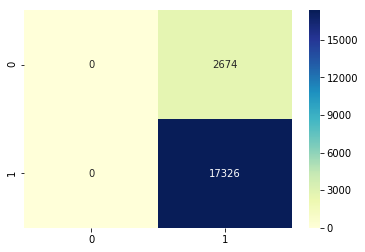

In [177]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [178]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [179]:
print('precision score for test set is ',(precision_score(y_test, testpred)*100))

precision score for test set is  86.63


In [180]:
print('recall score for test set is ',(recall_score(y_test, testpred)*100))

recall score for test set is  100.0


In [181]:
print('fbeta score for test set is ',(fbeta_score(y_test, testpred, beta=0.5,average='micro')*100))

fbeta score for test set is  86.63


### Again applying SMOTE for l1 regularizer

In [182]:
logreg=LogisticRegression(penalty='l1',random_state=42,n_jobs=2)

In [187]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000, 1200, 1500]}

In [188]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [189]:
model.fit(resampled_x, resampled_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1200, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [190]:
model.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
model.best_score_

0.70144872283879

### building model with the best estimators

In [192]:
logreg = LogisticRegression(C=1000, penalty='l1', random_state=42, n_jobs=2)

In [193]:
logreg.fit(resampled_x, resampled_y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [194]:
print('train error is ', 100 - (logreg.score(standard_tfidf_train, y_train)*100))

train error is  11.948333333333338


In [195]:
y_pred = logreg.predict(standard_tfidf_test)

In [196]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  85.41


In [197]:
cmat = confusion_matrix(y_test, y_pred)

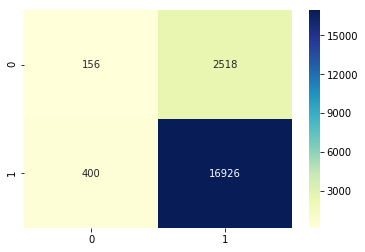

In [198]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [199]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [200]:
print('precision score for test set is ',(precision_score(y_test, y_pred)*100))

precision score for test set is  87.0499897140506


In [201]:
print('recall score for test set is ',(recall_score(y_test, y_pred)*100))

recall score for test set is  97.69133094770865


In [202]:
print('fbeta score for test set is ',(fbeta_score(y_test, y_pred, beta=0.5,average='micro')*100))

fbeta score for test set is  85.41


In [236]:
y_pred_prob = logreg.predict_proba(standard_tfidf_test)[:,1]

In [237]:
y_pred_prob.shape

(20000,)

In [238]:
from sklearn.metrics import roc_curve,roc_auc_score

In [239]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

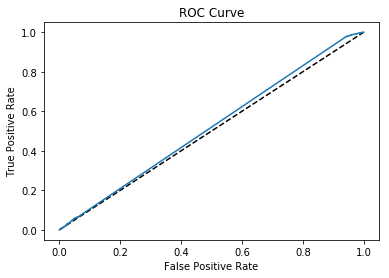

In [240]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [3]:
# Please write all the code with proper documentation

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [67]:
std = StandardScaler(with_mean=False)

In [68]:
standardizer = std.fit(train_tfidf)

In [69]:
standard_tfidf_train = standardizer.transform(train_tfidf)

In [70]:
standard_tfidf_test = standardizer.transform(test_tfidf)

In [71]:
standard_tfidf_cv = standardizer.transform(cv_tfidf)

### tfidf gridsearch cv - L2

In [72]:
logreg=LogisticRegression(penalty='l2',random_state=42,n_jobs=2)

In [73]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [74]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [75]:
model.fit(standard_tfidf_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [76]:
model.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

### applying the learned parameters to the model

In [77]:
logreg = LogisticRegression(C=0.001, penalty='l2', random_state=42, n_jobs=2)

In [78]:
logreg.fit(standard_tfidf_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
print('train error is ', 100 - (logreg.score(standard_tfidf_train, y_train)*100))

train error is  11.11


In [80]:
y_pred = logreg.predict(standard_tfidf_test)

In [81]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  86.485


In [82]:
cmat = confusion_matrix(y_test, y_pred)

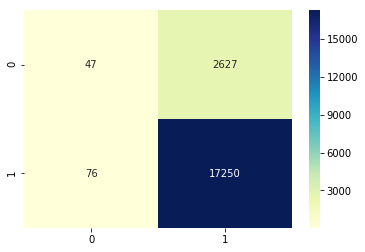

In [83]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [84]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 85%


In [85]:
print('the f1 score on test data is', (int(model.score(test_tfidf, y_test)*100)))

the f1 score on test data is 92


### Since our model is underfitting badly, we are gonna upsample this

In [86]:
from collections import Counter

In [87]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [88]:
smote = SMOTE(n_jobs=2, random_state=10, ratio=1.0,)

In [89]:
x_sampled,y_sampled = smote.fit_resample(standard_tfidf_train, y_train)

In [144]:
resampled_x = x_sampled[30000:80000, :]

In [145]:
resampled_x.shape

(50000, 2000)

In [146]:
resampled_y = y_sampled[30000:80000]

In [147]:
resampled_y.shape

(50000,)

In [148]:
Counter(resampled_y)

Counter({1: 26389, 0: 23611})

In [123]:
# weights={0:2, 1:5}

In [149]:
logreg=LogisticRegression(penalty='l2',random_state=42,n_jobs=2)

In [150]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [151]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [152]:
model.fit(resampled_x, resampled_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [153]:
model.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [154]:
model.best_score_

0.7012947611034576

In [155]:
Counter(resampled_y)

Counter({1: 26389, 0: 23611})

### building model with the best estimators

In [156]:
logreg = LogisticRegression(C=0.1, penalty='l2', random_state=42, n_jobs=2)

In [157]:
logreg.fit(resampled_x, resampled_y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [158]:
print('train error is ', 100 - (logreg.score(standard_tfidf_train, y_train)*100))

train error is  11.969999999999999


In [159]:
y_pred = logreg.predict(standard_tfidf_test)

In [160]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  85.385


In [161]:
cmat = confusion_matrix(y_test, y_pred)

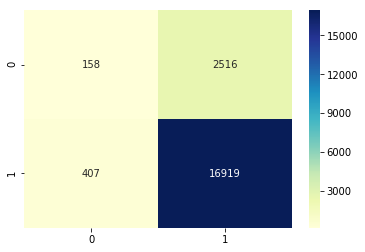

In [162]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### THE MODEL HAS IMPROVED DETECTING 123 CORRECT 0'S TO 565 0'S

In [138]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [163]:
print('precision score for test set is ',(precision_score(y_test, y_pred)*100))

precision score for test set is  87.05428350913301


In [164]:
print('recall score for test set is ',(recall_score(y_test, y_pred)*100))

recall score for test set is  97.65092923929355


In [165]:
print('fbeta score for test set is ',(fbeta_score(y_test, y_pred, beta=0.5,average='micro')*100))

fbeta score for test set is  85.385


In [280]:
from sklearn.metrics import roc_curve,roc_auc_score

In [279]:
y_pred_prob = logreg.predict_proba(standard_tfidf_test)[:,1]

In [281]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

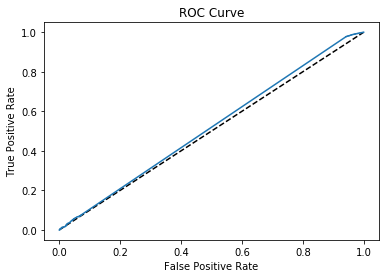

In [282]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [3]:
# Please write all the code with proper documentation

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
tfidf = TfidfVectorizer(max_features=2000, min_df=3)

In [64]:
tf = tfidf.fit_transform(postext)

In [65]:
feature_names = tfidf.get_feature_names()

In [67]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [69]:
logreg = LogisticRegression()

In [71]:
logreg.fit(standard_tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
show_most_informative_features(tfidf, logreg)

	-0.2351	highest        		0.3881	live           
	-0.1126	ride           		0.3860	attract        
	-0.0985	catch          		0.3029	salmon         
	-0.0977	mind           		0.2567	grow           
	-0.0905	thrill         		0.1968	someth         
	-0.0883	comparison     		0.1784	sip            
	-0.0877	yeah           		0.1776	supermarket    
	-0.0866	six            		0.1725	diet           
	-0.0812	differ         		0.1622	fortun         
	-0.0806	fridg          		0.1619	serv           
	-0.0806	hour           		0.1612	sugar          
	-0.0806	subtl          		0.1605	smell          
	-0.0779	royal          		0.1541	familiar       
	-0.0774	strang         		0.1470	unit           
	-0.0756	actual         		0.1460	routin         
	-0.0710	faster         		0.1437	rum            
	-0.0673	cranberri      		0.1435	mom            
	-0.0662	compani        		0.1415	mention        
	-0.0636	steel          		0.1404	fact           
	-0.0634	god            		0.1348	occas          


In [3]:
# Please write all the code with proper documentation

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
tfidf = TfidfVectorizer(max_features=2000, min_df=3)

In [75]:
tf = tfidf.fit_transform(negtext)

In [76]:
feature_names = tfidf.get_feature_names()

In [77]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [78]:
logreg = LogisticRegression()

In [80]:
logreg.fit(standard_tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [81]:
show_most_informative_features(tfidf, logreg)

	-0.2351	hesit          		0.3881	lime           
	-0.1126	repli          		0.3860	aspartam       
	-0.0985	cardboard      		0.3029	room           
	-0.0977	messag         		0.2567	greasi         
	-0.0905	thrill         		0.1968	soak           
	-0.0883	complex        		0.1784	show           
	-0.0877	yard           		0.1776	sunflow        
	-0.0866	sick           		0.1725	determin       
	-0.0812	diabet         		0.1622	float          
	-0.0806	fortun         		0.1619	seawe          
	-0.0806	horrid         		0.1612	sucker         
	-0.0806	substanc       		0.1605	sister         
	-0.0779	ridicul        		0.1541	expir          
	-0.0774	store          		0.1470	unhealthi      
	-0.0756	activ          		0.1460	rid            
	-0.0710	face           		0.1437	ring           
	-0.0673	cranberri      		0.1435	mislead        
	-0.0662	complaint      		0.1415	meal           
	-0.0636	station        		0.1404	exchang        
	-0.0634	giant          		0.1348	normal         


In [3]:
# Please write all the code with proper documentation

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

### AVGW2V L1 REGULARIZER

In [229]:
logreg=LogisticRegression(penalty='l1',random_state=42,n_jobs=2)

In [230]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [231]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [232]:
model.fit(standard_avgw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [233]:
model.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [234]:
model.best_score_

0.9501348945604858

### APPLYING LEARNED VALUES

In [235]:
logreg = LogisticRegression(C=0.1, penalty='l1', random_state=42, n_jobs=2)

In [236]:
logreg.fit(standard_avgw2v_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [237]:
print('train error is ', 100 - (logreg.score(standard_avgw2v_train, y_train)*100))

train error is  9.033333333333331


In [238]:
y_pred = logreg.predict(standard_avgw2v_test)

In [239]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  89.725


In [240]:
cmat = confusion_matrix(y_test, y_pred)

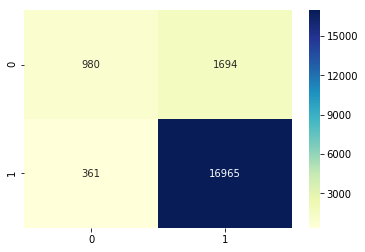

In [241]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [242]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [243]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 81%


In [244]:
print('the f1 score on test data is', (int(model.score(standard_avgw2v_test, y_test)*100)))

the f1 score on test data is 94


In [325]:
y_pred_prob = logreg.predict_proba(standard_avgw2v_test)[:,1]

In [326]:
y_pred_prob.shape

(20000,)

In [327]:
from sklearn.metrics import roc_curve,roc_auc_score

In [328]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

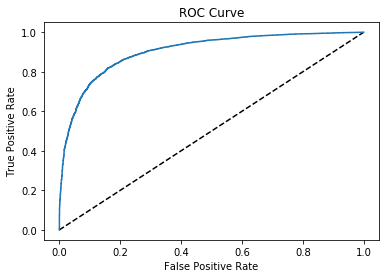

In [329]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
standardizer = std.fit(tfidfw2v_train)

In [ ]:
standard_tfidfw2v_train = standardizer.transform(tfidfw2v_train)

In [285]:
standard_tfidfw2v_test = standardizer.transform(tfidfw2v_test)

In [286]:
standard_tfidfw2v_cv = standardizer.transform(tfidfw2v_cv)

In [287]:
logreg=LogisticRegression(penalty='l2',random_state=42,n_jobs=2)

In [288]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [289]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [290]:
model.fit(standard_tfidfw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [291]:
model.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [292]:
model.best_score_

0.9464326531761904

### applying the learned parameters to the model

In [293]:
logreg = LogisticRegression(C=0.1, penalty='l2', random_state=42, n_jobs=2)

In [294]:
logreg.fit(standard_tfidfw2v_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [295]:
print('train error is ', 100 - (logreg.score(standard_avgw2v_train, y_train)*100))

train error is  9.519999999999996


In [296]:
y_pred = logreg.predict(standard_tfidfw2v_test)

In [297]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  88.59000000000002


In [298]:
cmat = confusion_matrix(y_test, y_pred)

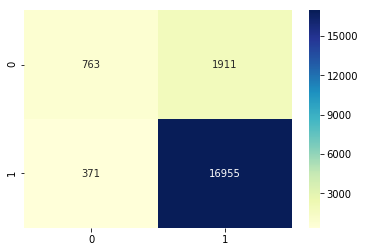

In [299]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [300]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [301]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 82%


In [302]:
print('the f1 score on test data is', (int(model.score(standard_avgw2v_test, y_test)*100)))

the f1 score on test data is 93


In [304]:
y_pred_prob = logreg.predict_proba(standard_avgw2v_test)[:,1]

In [305]:
y_pred_prob.shape

(20000,)

In [306]:
from sklearn.metrics import roc_curve,roc_auc_score

In [307]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

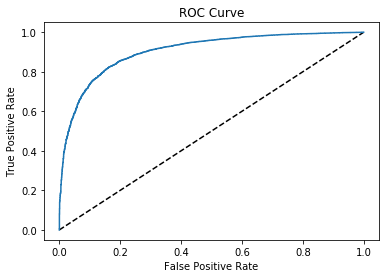

In [308]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### L2 with random search

In [245]:
logreg = LogisticRegression(penalty='l2',random_state=42,n_jobs=2)

In [247]:
from scipy.stats import uniform

In [248]:
params={'C': uniform()}

In [249]:
randmodel = RandomizedSearchCV(estimator=logreg, param_distributions=params, scoring='f1', cv=10)

In [250]:
randmodel.fit(standard_avgw2v_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A4FA53DA0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [251]:
randmodel.best_estimator_

LogisticRegression(C=0.3253700401329864, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=2, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [252]:
randmodel.best_score_

0.9501465106217293

### Building Logistic regression model based on result from RandomSearch

In [253]:
logreg = LogisticRegression(C=0.3253700401329864,penalty='l2',random_state=42,n_jobs=2)

In [254]:
logreg.fit(standard_avgw2v_train, y_train)

LogisticRegression(C=0.3253700401329864, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=2, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [255]:
y_pred = logreg.predict(standard_avgw2v_test)

In [256]:
print('f1 score for testing set in randomsearch with l2 regularization is ', f1_score(y_test, y_pred))

f1 score for testing set in randomsearch with l2 regularization is  0.942960489705064


In [257]:
print('score on the test data is',(randmodel.score(standard_avgw2v_test, y_test)))

score on the test data is 0.942960489705064


### Performance measures

In [258]:
cmat = confusion_matrix(y_test, y_pred)

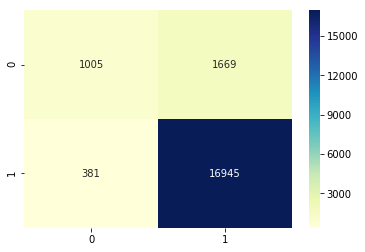

In [259]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [260]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [261]:
print('precision score for test set is ',(precision_score(y_test, y_pred)*100))

precision score for test set is  91.03363060062318


In [262]:
print('recall score for test set is ',(recall_score(y_test, y_pred)*100))

recall score for test set is  97.80099272769249


In [263]:
print('fbeta score for test set is ',(fbeta_score(y_test, y_pred, beta=0.5,average='micro')*100))

fbeta score for test set is  89.75000000000001


In [3]:
# Please write all the code with proper documentation

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
logreg = LogisticRegression(penalty='l1',random_state=42,n_jobs=2)

In [265]:
params={'C': uniform()}

In [266]:
randmodel = RandomizedSearchCV(estimator=logreg, param_distributions=params, scoring='f1', cv=10)

In [267]:
randmodel.fit(standard_avgw2v_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l1', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A50DA76A0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [268]:
randmodel.best_estimator_

LogisticRegression(C=0.953575729870462, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=2, penalty='l1', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Building Logistic regression model based on result from RandomSearch

In [269]:
logreg = LogisticRegression(C=0.953575729870462,penalty='l1',random_state=42,n_jobs=2)

In [270]:
logreg.fit(standard_avgw2v_train, y_train)

LogisticRegression(C=0.953575729870462, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=2, penalty='l1', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [271]:
y_pred = logreg.predict(standard_avgw2v_test)

In [272]:
print('f1 score for testing set in randomsearch with l2 regularization is ', f1_score(y_test, y_pred))

f1 score for testing set in randomsearch with l2 regularization is  0.942852373268043


In [274]:
print('score on the test data is',(randmodel.score(standard_avgw2v_test, y_test)))

score on the test data is 0.942852373268043


### Performance measures

In [275]:
cmat = confusion_matrix(y_test, y_pred)

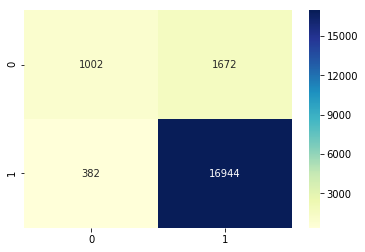

In [276]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [277]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [278]:
print('precision score for test set is ',(precision_score(y_test, y_pred)*100))

precision score for test set is  91.01847872797593


In [279]:
print('recall score for test set is ',(recall_score(y_test, y_pred)*100))

recall score for test set is  97.79522105506176


In [280]:
print('fbeta score for test set is ',(fbeta_score(y_test, y_pred, beta=0.5,average='micro')*100))

fbeta score for test set is  89.73


In [383]:
y_pred_prob = logreg.predict_proba(standard_tfidfw2v_test)[:,1]

In [384]:
y_pred_prob.shape

(20000,)

In [385]:
from sklearn.metrics import roc_curve,roc_auc_score

In [386]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

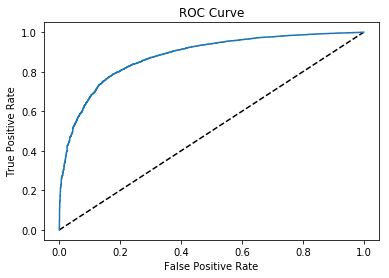

In [387]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [3]:
# Please write all the code with proper documentation

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [283]:
standardizer = std.fit(tfidfw2v_train)

In [284]:
standard_tfidfw2v_train = standardizer.transform(tfidfw2v_train)

In [285]:
standard_tfidfw2v_test = standardizer.transform(tfidfw2v_test)

In [286]:
standard_tfidfw2v_cv = standardizer.transform(tfidfw2v_cv)

In [287]:
logreg=LogisticRegression(penalty='l2',random_state=42,n_jobs=2)

In [288]:
gridvalues = {'C': [0.001,0.01,0.1,1,10,100,1000]}

In [289]:
model = GridSearchCV(estimator=logreg, param_grid=gridvalues, scoring='f1',cv=10)

In [290]:
model.fit(standard_tfidfw2v_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [291]:
model.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [292]:
model.best_score_

0.9464326531761904

### applying the learned parameters to the model

In [293]:
logreg = LogisticRegression(C=0.1, penalty='l2', random_state=42, n_jobs=2)

In [294]:
logreg.fit(standard_tfidfw2v_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=2,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [295]:
print('train error is ', 100 - (logreg.score(standard_avgw2v_train, y_train)*100))

train error is  9.519999999999996


In [296]:
y_pred = logreg.predict(standard_tfidfw2v_test)

In [297]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  88.59000000000002


In [298]:
cmat = confusion_matrix(y_test, y_pred)

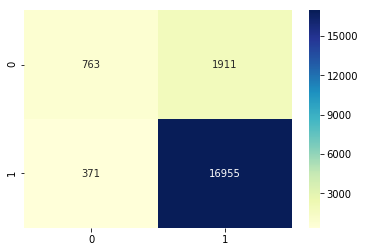

In [299]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

In [300]:
Counter(y_test)

Counter({1: 17326, 0: 2674})

In [301]:
f1 = f1_score(y_cv, y_pred, average='micro')*100
print('the f1 score on cross validation set is %d%%' %(f1))

the f1 score on cross validation set is 82%


In [302]:
print('the f1 score on test data is', (int(model.score(standard_avgw2v_test, y_test)*100)))

the f1 score on test data is 93


In [362]:
y_pred_prob = logreg.predict_proba(standard_tfidfw2v_test)[:,1]

In [363]:
y_pred_prob.shape

(20000,)

In [364]:
from sklearn.metrics import roc_curve,roc_auc_score

In [365]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

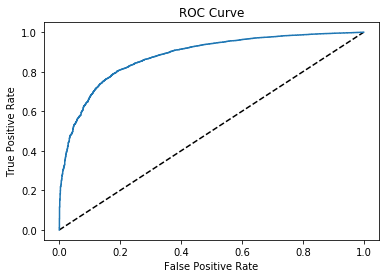

In [366]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [3]:
# Please write all the code with proper documentation

# [6] Conclusions

In [2]:
import pandas as pd

In [5]:
from prettytable import PrettyTable

In [26]:
x = PrettyTable()

In [27]:
x.field_names = ['regularizer','vectorizer', 'f1score', 'precision', 'recall']

In [43]:
x.add_row(['l1', 'avgw2v',89,94,94])

In [41]:
x.del_row(5)

In [44]:
print(x)

+-------------+------------+---------+-----------+--------+
| regularizer | vectorizer | f1score | precision | recall |
+-------------+------------+---------+-----------+--------+
|      l1     |    bow     |    91   |     93    |   97   |
|      l2     |    bow     |    91   |     93    |   97   |
|      l1     |   tfidf    |    85   |     87    |   97   |
|      l2     |   tfidf    |    85   |     87    |   97   |
|      l1     |   avgw2v   |    89   |     81    |   94   |
|      l1     |  tfidfw2v  |    94   |     91    |   97   |
|      l2     |  tfidfw2v  |    93   |     83    |   87   |
|      l1     |   avgw2v   |    89   |     94    |   94   |
+-------------+------------+---------+-----------+--------+


### conclusion

Eventhough over model performed poor at some situations. I feel this can be improved to some extent by doing some extensive hyperparameter tuning and feature engineering if needed. This should improve the model's performance